<a href="https://colab.research.google.com/github/tutorials101/gradCAM/blob/main/saliency_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Vanilla Implementation
Saliency Maps: CAM, Grad-CAM, Guided Grad-CAM, Grad-CAM++

In [ ]:
!git clone https://github.com/tutorials101/gradCAM.git

fatal: destination path 'gradCAM' already exists and is not an empty directory.


In [94]:
import torch

from torchvision import models
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [ ]:
#We're going to be using ResNet18


weights = models.ResNet18_Weights.IMAGENET1K_V1
net = models.resnet18(weights=weights, progress=True)

net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [95]:
# the preprocessing steps that this model used while training the imagnet dataset

# preprocess = weights.transforms() #there is this cropping step as well, but we don't want that

preprocess = transforms.Compose([
    transforms.Resize(224),
    # transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


print(preprocess)

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [121]:
# Some utility functions

hooked_layers = {}

def forward_hook(name):

  def _hook(module, input, output):

    if name not in hooked_layers:
      hooked_layers[name] = {}

    hooked_layers[name]["out"] = output

  return _hook

def backward_hook(name):

  def _hook(module, input_grad, output_grads):

    if name not in hooked_layers:
      hooked_layers[name] = {}

    hooked_layers[name]["out_grad"] = output_grads[0]

  return _hook

(630, 1200, 3)


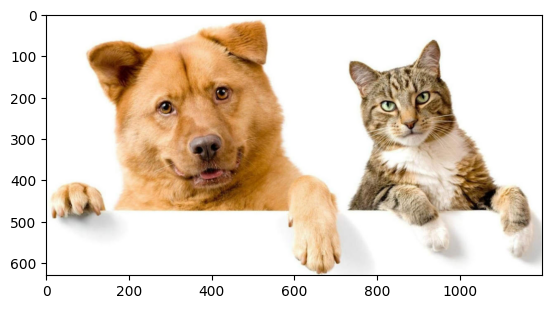

In [97]:
#Example input, this is an image of cat and dog

img_path = "gradCAM/examples/example2.jpg"

img = Image.open(img_path)
print(np.array(img).shape)
plt.imshow(img)


(224, 426, 3)


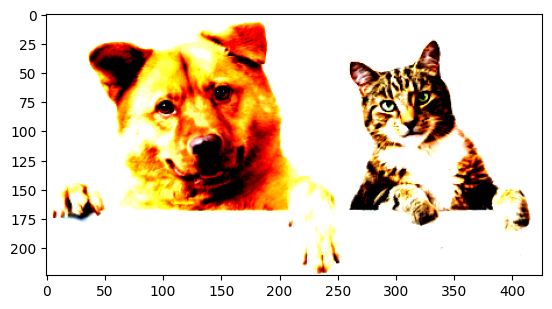

In [98]:
input = preprocess(img)
print(input.numpy().transpose(1,2,0).shape)
plt.imshow(input.numpy().transpose(1,2,0))

### <> **1. CAM (Not GradCAM)** - Idea is as follows:
- immediately after the conv layer for which you want to see the CAM, you apply global average pooling (mean channel-wise activation)
- GAP is followed by a classification layer which you have to train. In the classification layer , each neuron represents the score (weighted sum of mean channel-wise actions) associated with a specific class.
- You choose the neuron/class for which you want to see the activation maps and the get their weights
- Then you multiply with the conv-layer activations with those weights to obtain the CAM

[In resnet18, we can easily obtain CAM associated with the final conv layer - layer4.basicblock1.conv2; because there is a GAP and classification layer. However for other conv layers, it is not possible to obtain CAM. This why people came up with gradCAM]


In [99]:
# relevant class idx, associated with the examples

# 385	Indian elephant, Elephas maximus
# 386	African elephant, Loxodonta africana
# 281	tabby, tabby cat
# 260	chow, chow chow, a kind of dog

def get_cam(class_idx):

  assert "final_conv" in hooked_layers, "you need to do a hooked forward pass before you can get the cam"

  A = hooked_layers['final_conv']["out"][0]
  w = dict(net.fc.named_parameters())["weight"][class_idx]

  cam = (A * w.view(A.shape[0],1,1)).sum(dim=[0]).detach().numpy()

  return cam

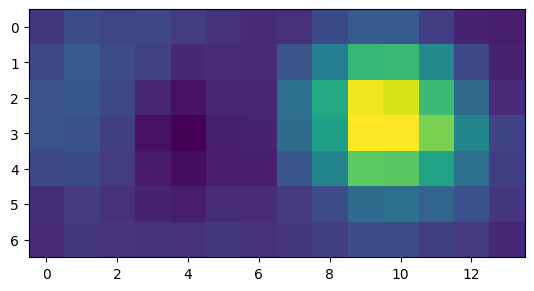

In [100]:
# hooking the conv layer, for which you want to see the CAM
h1 = net.layer4[1].conv2.register_forward_hook(forward_hook('final_conv'))

# for the batch norm params to be adjusted
net.eval()

#forward pass
scores = net(input.unsqueeze(0))

# removing the forward hook handle
h1.remove()

class_idx = torch.argmax(scores)
cam = get_cam(class_idx)

plt.imshow(cam)

class_idx.item()=281, scores[:, class_idx].item()=7.31249475479126


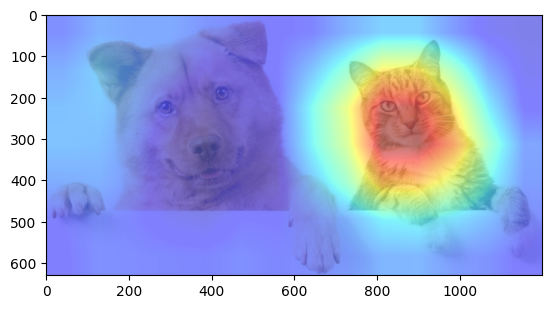

In [101]:
plt.imshow(img, alpha=0.5)
plt.imshow(cv2.resize(cam, img.size), alpha=0.5, cmap='jet')

print(f"{class_idx.item()=}, {scores[:, class_idx].item()=}")

#281 is tabby cat

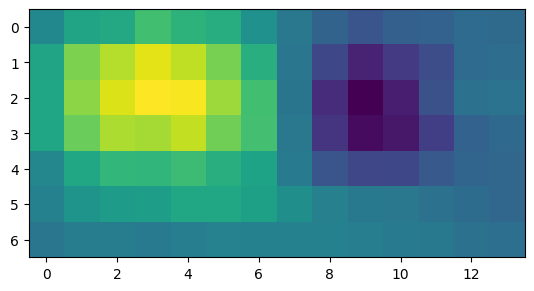

In [102]:
# Now let's try for the dog, class_idx=260, chow
class_idx = 260
cam = get_cam(class_idx)

plt.imshow(cam)

class_idx=260, scores[:, class_idx].item()=5.149387359619141


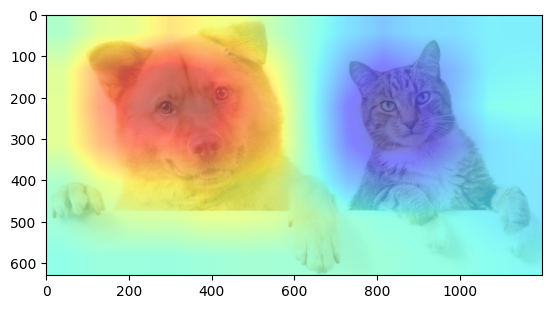

In [103]:
plt.imshow(img, alpha=0.5)
plt.imshow(cv2.resize(cam, img.size), alpha=0.5, cmap='jet')

print(f"{class_idx=}, {scores[:, class_idx].item()=}")

#260 is dog

### <> **2. Grad CAM** - Idea is as follows:
- Forward hook the conv layer, to obtain the activations for which you want to see the CAM
- Backward hook the same conv layer, to obtain the gradient with respect to the output activations. When you backprop, only do backward on the desired class index
- Estimate the weights
- Then you multiply with the conv-layer activations with those weights to obtain the CAM

[we are going to use resnet18's layer4.basicblock1.conv2]

class_idx.item()=281, scores[:, class_idx].item()=7.31249475479126


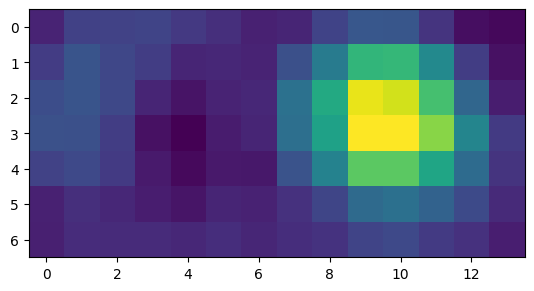

In [142]:
def get_gradcam(input, conv_layer, class_idx=None):

  if isinstance(class_idx, int):
    class_idx = torch.tensor(class_idx)

  h1 = conv_layer.register_forward_hook(forward_hook("conv_layer"))
  h2 = conv_layer.register_full_backward_hook(backward_hook("conv_layer"))

  net.eval()

  scores = net(input)

  if not class_idx:
    class_idx = torch.argmax(scores)

  class_score = scores[:, class_idx]
  class_score.backward()

  h1.remove()
  h2.remove()

  Z = hooked_layers["conv_layer"]["out"][0]
  w = hooked_layers["conv_layer"]["out_grad"][0].mean(dim=[1,2], keepdims=True)

  gradcam = (Z*w).sum(dim=[0])

  print(f"{class_idx.item()=}, {scores[:, class_idx].item()=}")

  return gradcam.detach().numpy()



gradcam = get_gradcam(input.unsqueeze(0), net.layer4[1].conv2) # if interested, we can pass it to a ReLU to only focus on the positive influence
plt.imshow(gradcam)


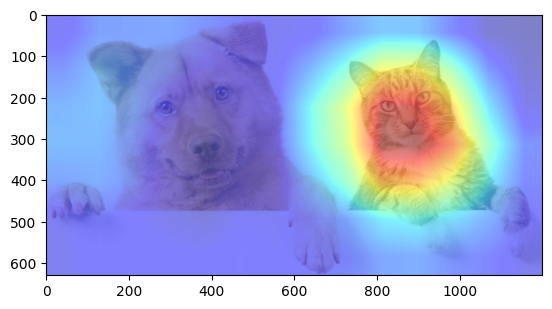

In [138]:
plt.imshow(img, alpha=0.5)
plt.imshow(cv2.resize(gradcam, img.size), alpha=0.5, cmap='jet')


class_idx.item()=260, scores[:, class_idx].item()=5.149387359619141


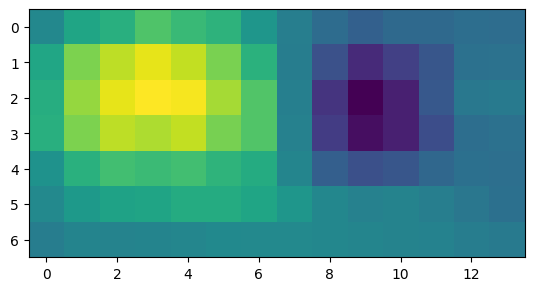

In [143]:
# Now let's try for the dog, class_idx=260, chow
class_idx = 260
gradcam = get_gradcam(input.unsqueeze(0), net.layer4[1].conv2, class_idx)

plt.imshow(gradcam)

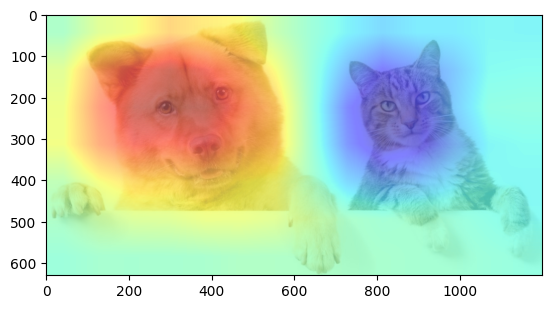

In [144]:
plt.imshow(img, alpha=0.5)
plt.imshow(cv2.resize(gradcam, img.size), alpha=0.5, cmap='jet')

**NOTE: The output of CAM and gradCAM are the same. The main difference is that with gradCAM, there is no architectural constraint (GAP-> class); Also we can choose arbitrary layers to visualize**

class_idx.item()=281, scores[:, class_idx].item()=7.31249475479126


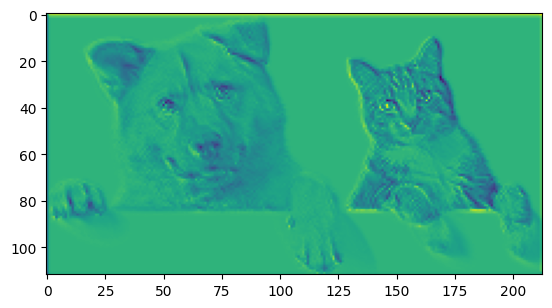

In [152]:
# Let's try an arbitrary layer -> net.conv1, the first conv layer
gradcam = get_gradcam(input.unsqueeze(0), net.conv1) #
plt.imshow(gradcam)

class_idx.item()=260, scores[:, class_idx].item()=5.149387359619141


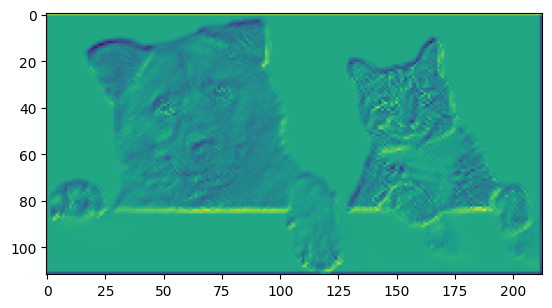

In [155]:
# Let's try an arbitrary layer -> net.conv1, the first conv layer
gradcam = get_gradcam(input.unsqueeze(0), net.conv1, 260) #
plt.imshow(gradcam)

### <> **3. Guided Grad CAM** - Idea is GradCAM + Guided Backprop

[we are going to use resnet18's layer4.basicblock1.conv2]